In [2]:
import numpy as np
import math
import pandas as pd
from astropy.io import fits
import random
from scipy import integrate

#Set up matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as plc

# Import Leo's code
import sed_evaluation as sed


In [3]:
def sed_simulation(param): #
    # param[0]: log10 SFR in the first 10 Myr
    # param[1]: log10 SFR in the 10-100 Myr
    # param[2]: log10 SFR in the 100 - 1000 Myr
    p = np.power(10., param)
    sfr_fn = lambda t: p[0] * (t<1e7) + p[1] * (t>1e7) * (t<1e8) + p[2] * (t>1e8) * (t<1e9)
    sed_sim = sed.generate_total_SED(sfr_fn, sed.sed)
    return sed_sim


def integrand(wavelength, param,waves,throughputs,z):
    # param[0]: log10 SFR in the first 10 Myr
    # param[1]: log10 SFR in the 10-100 Myr
    # param[2]: log10 SFR in the 100 - 1000 Myr
    sed_interpolate = np.interp((wavelength), (sed.sed.get_wavelength()/(10**4))*((1+z)), 
                               (sed_simulation(param))/((1+z)),
                               left=0, right=0)
    throughput=np.interp(wavelength,waves,throughputs)
    total = sed_interpolate*throughput
    return total


def within_filter_patchSED(wavelength, param,z):
    # param[0]: log10 SFR in the first 10 Myr
    # param[1]: log10 SFR in the 10-100 Myr
    # param[2]: log10 SFR in the 100 - 1000 Myr
    patch_sed_interpolate = np.interp((wavelength), (sed.sed.get_wavelength()/(10**4))*((1+z)), 
                                      (sed_simulation(param))/((1+z)))
    throughput=np.interp(wavelength,jwst_waves,jwst_throughput)    
    return patch_sed_interpolate*throughput

def sersic_profile(radius):
    intensity_value = float(np.exp(-5*(((radius/10)**0.25)-1)))
    return intensity_value

def norm_sersic_profile(radius):
    intensity_value = float(2*np.pi*radius*np.exp(-5*(((radius/10)**0.25)-1)))
    return intensity_value
    

def transformation(smallest_pixel,galaxy_distance,magnification,row,column):
    #smallest_pixel = the width of each pixel in radians; 
    #galaxy_distance = the distance of the galaxy (watch out for units!);
    #magnification = the magnification of the galaxy; 
    #row, column = the coordinate of a pixel
    
    galaxy_pixel_radius = math.sqrt((column-center_i)**2+(row-center_j)**2) #center_i and center_j has not been generalized yet
    galaxy_pixel_angle=smallest_pixel*galaxy_pixel_radius # Calculating the angular size of a radius of a galaxy in the pixel array
    galaxy_radius=galaxy_distance*galaxy_pixel_angle # Using the distance formula to calculate the true galaxy radius
                                                            # we observe
    return galaxy_radius

def shot_noise(intensity):
    shot_noise=np.random.poisson(lam=math.sqrt(intensity))
    return shot_noise
    
def sky_noise():
    # to be added
    return

def dark_current_noise():
    # to be added
    return

def read_noise():
    # to be added
    return


Using matplotlib backend: nbAgg
21


<IPython.core.display.Javascript object>


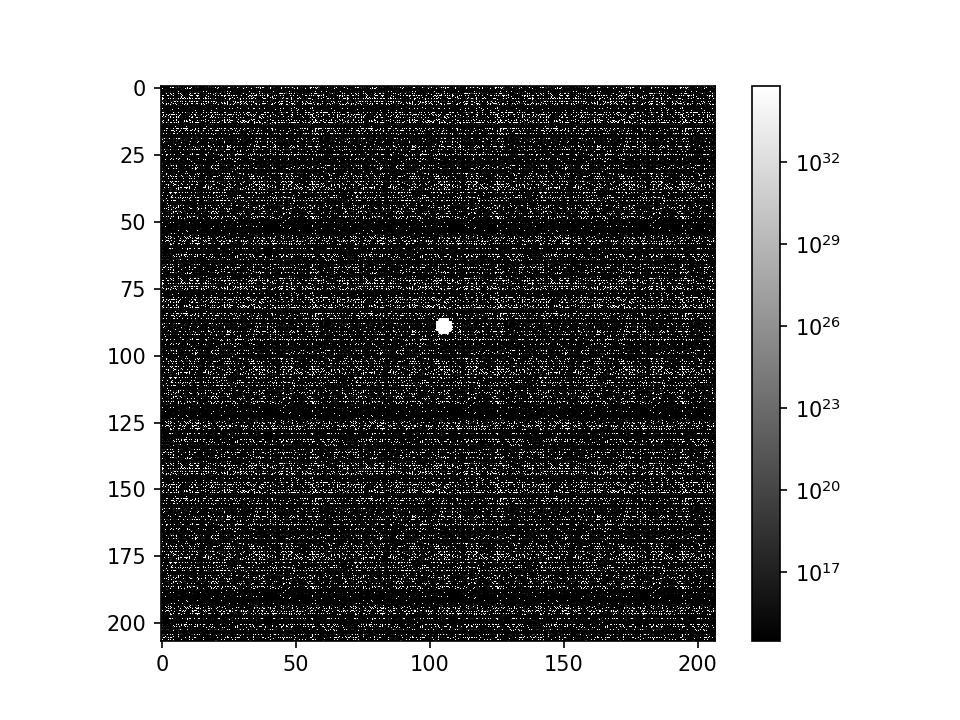

(4812.633291319427, 5.610965672531165e-06)


In [8]:
%matplotlib 

file_name=['F070W','F090W','F115W','F140M','F150W','F150W2','F162M','F164N','F444W']

pixel_scale = 0.063 # In arcseconds, this is the angular size per pixel
telescope_focal=100 # In arbitrary units, this is the telescope focal length
eyepiece_focal=10 # In arbitrary units, this is the eyepiecec focal length
magnification=telescope_focal/eyepiece_focal # Magnification of the galaxy image

quantum_efficiency = 0.75 # Insert any value from 0-1 of the CCD sensor

redshift = 2

n=101 # Just a random number to generate the amount of pixel
total_rows=2*n+5
total_columns=2*n+5
# a = np.zeros(shape=(total_rows,total_columns,len(filter_intensity)))
center_i = int((total_rows-1)/2)
center_j = int((total_columns-1)/2)

filter_intensity=[] # The values in this array is ordered to be the same as the file_name
patch_filter_intensity=[]

normalization_const = integrate.quad(norm_sersic_profile, 0, 100000)


for file in file_name:
    data  = pd.read_csv("{0}.csv".format(file))
    xdata = data.microns # Wavelength in units of micrometer
    ydata = data.throughput # The throughput for each wavelength in jwst_wave

    
    jwst_waves=[]
    for wave in xdata:
        jwst_waves.append(wave)
            
    
    jwst_throughput = []
    
    for throughput in ydata:
        jwst_throughput.append(throughput)
        
        
    delta_lambda=np.abs(np.array(jwst_waves[1:])-np.array(jwst_waves[:-1]))
    
    filter_norm = np.sum((np.array(jwst_throughput[1:])+np.array(jwst_throughput[:-1])*delta_lambda))/2
    
#     for throughput in jwst_throughput:
#         throughput_normalized=throughput/filter_norm
#         jwst_throughput.append(throughput_normalized)
        
    jwst_throughput=np.array(jwst_throughput)/filter_norm
    
    # Integrating throughout the wavelengths to get the intensity absorbed by the filter
    function = integrand(jwst_waves,[0,0,-1],jwst_waves,jwst_throughput,redshift)
#     delta_lambda=np.abs(np.array(jwst_waves[1:])-np.array(jwst_waves[:-1]))
    result = np.sum((function[1:]+function[:-1])*delta_lambda)/2
    filter_intensity.append(result)
    
#     patch_function=integrand(jwst_waves,[10,0,0])
#     patch_result = np.sum((patch_function[1:]+patch_function[:-1])*delta_lambda)/2
#     patch_filter_intensity.append(result)

    # Integrating for the patch intensity that the filter gets
    patch_function = within_filter_patchSED(jwst_waves,[np.log(0.05),0,0],redshift)
    patch_result=np.sum((patch_function[1:]+patch_function[:-1])*delta_lambda)/2
    patch_filter_intensity.append(patch_result)


a = np.zeros(shape=(total_rows,total_columns,len(filter_intensity))) # Setting up the array

# Bin each intensity values to a corresponding pixel
for i in range(total_rows):
    for j in range(total_columns):
        for k in range(len(filter_intensity)):
            a[i][j][k]=((sersic_profile(transformation(0.06,1,10,i,j))/normalization_const[0]))*shot_noise(filter_intensity[k])

##### For random patches
# random_center_i= random.randint(int(0.5*n+1), int(n+2+(0.5*(n+3))))
# random_center_j=random.randint(int(0.5*n+1), int(n+2+(0.5*(n+3))))
random_center_i= random.randint(int(n-15), int(n+15))
random_center_j= random.randint(int(n-15), int(n+15))

max_patch_radius=3
random_patch_radius = random.uniform(2, max_patch_radius)


count = 0

for i in range(total_rows):
    for j in range(total_columns):
        patch_radius = math.sqrt((i-random_center_i)**2+(j-random_center_j)**2)
        if patch_radius<= random_patch_radius:
            count += 1

print(count)

for i in range(total_rows):
    for j in range(total_columns):
        patch_radius = math.sqrt((i-random_center_i)**2+(j-random_center_j)**2)
        if patch_radius<= random_patch_radius:        
            for k in range(len(patch_filter_intensity)):
                a[i][j][k]+=patch_filter_intensity[k]/count
        
## Addinf the shot noise (optional) ##               
# for i in range(total_rows):
#     for j in range(total_columns):
#         for k in range(len(file_name)):
#             print(shot_noise(a[i][j][k]))
#             a[i][j][k]=a[i][j][k]+shot_noise(a[i][j][k])

plt.imshow(a[:,:,1], cmap='gray',norm=plc.LogNorm())
plt.colorbar()





<IPython.core.display.Javascript object>


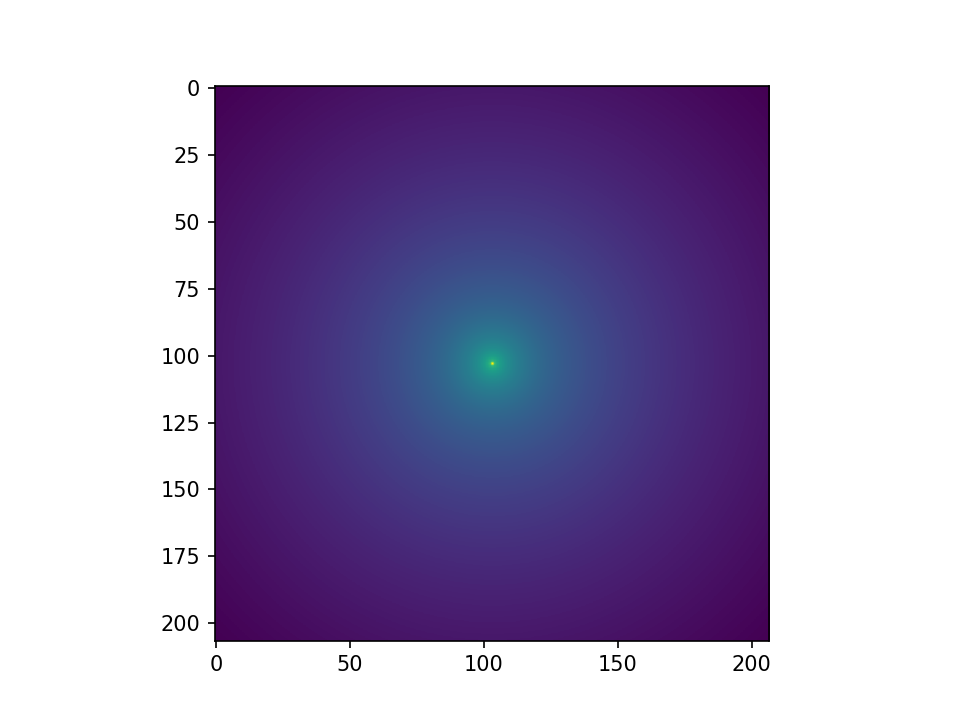

In [9]:
test=np.zeros(shape=(total_rows,total_columns))
%matplotlib notebook             
for i in range(total_rows):
    for j in range(total_columns):
        test[i][j]=sersic_profile(transformation(0.06,1,10,i,j)/normalization_const[0])
            
plt.imshow(test)
            

<IPython.core.display.Javascript object>


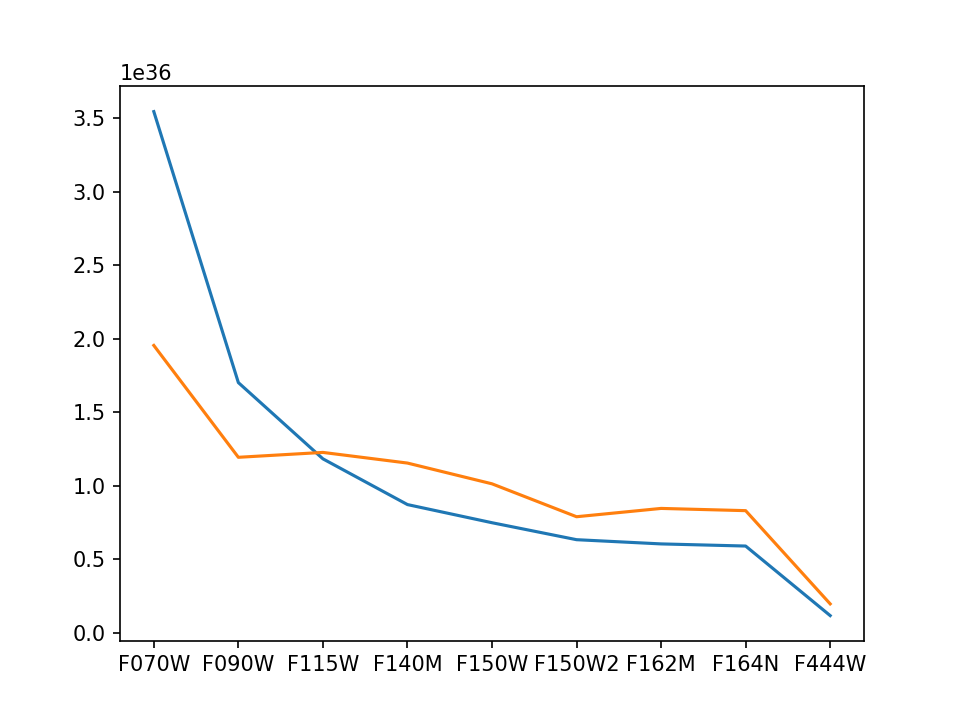

In [11]:
%matplotlib notebook
plt.plot(file_name[:], filter_intensity[:])
plt.plot(file_name[:], patch_filter_intensity[:])



1.1665438849482969e+35


<IPython.core.display.Javascript object>


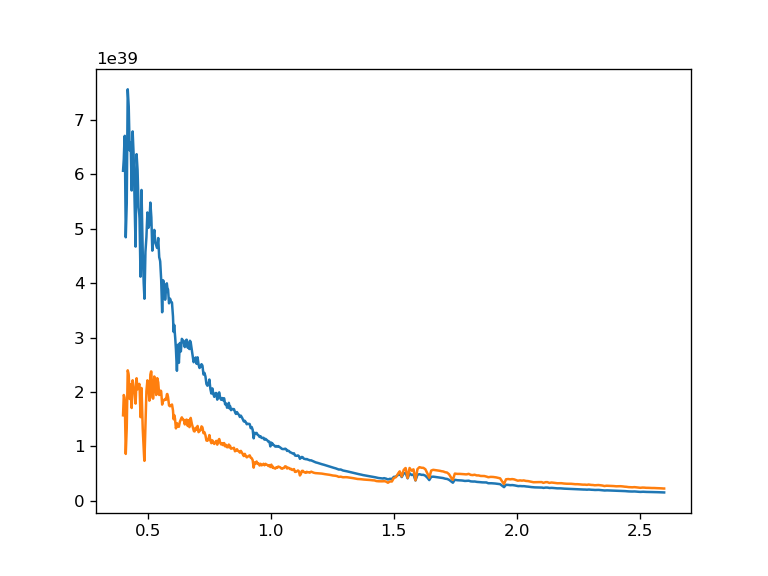

[6.06551373e+39 6.13321718e+39 6.20092062e+39 ... 1.50903326e+38
 1.51090786e+38 1.51278246e+38]
[0.39914999 0.40014999 0.40114999 ... 2.5971499  2.5981499  2.5991499 ]
[9.09e-03 9.35e-03 9.61e-03 ... 1.20e+02 1.40e+02 1.60e+02]


In [38]:
# file_name=['F070W','F090W','F115W','F140M','F150W','F150W2','F162M','F164N','F444W']

file ='F070W'
%matplotlib notebook
data  = pd.read_csv("{0}.csv".format(file))
xdata = data.microns # Wavelength in units of micrometer
ydata = data.throughput # The throughput for each wavelength in jwst_wave
redshift=3
    
jwst_waves=[]

for wave in xdata:
    jwst_waves.append(wave)

jwst_waves=np.array(jwst_waves)


# print(index_waves[0])
delta_lambda=np.abs(np.array(jwst_waves[1:])-np.array(jwst_waves[:-1]))       

jwst_throughput = []

for throughput in ydata:
    jwst_throughput.append(throughput)
    

# function=integrand(jwst_waves, [0,0,-1],jwst_waves,jwst_throughput)
# result = np.sum((function[1:]+function[:-1])*delta_lambda)/2
print(result) # This is the light the filter catches integrated throughout the wavelengths and already consider the thrputs

# sed_interpolate = np.interp(np.log10(jwst_waves), np.log10(sed.sed.get_wavelength()/10**4)+np.log10((1+redshift)), 
#                             np.log10(sed_simulation([0,0,-1]))-np.log10((1+redshift)),
#                            left=0,right=0)

# sed_interpolate2 = np.interp(np.log10(jwst_waves), np.log10(sed.sed.get_wavelength()/10**4)+np.log10((1+redshift)), 
#                              np.log10(sed_simulation([np.log10(0.05),0,0]))-np.log10((1+redshift)),
#                             left=0,right=0)

sed_interpolate = np.interp(jwst_waves, (sed.sed.get_wavelength()/10**4)*((1+redshift)), 
                            (sed_simulation([0,0,-1]))/((1+redshift)),
                           left=0,right=0)

sed_interpolate2 = np.interp(jwst_waves, (sed.sed.get_wavelength()/10**4)*((1+redshift)), 
                            (sed_simulation([np.log10(0.05),0,0]))/((1+redshift)),
                           left=0,right=0)

plt.plot(jwst_waves, sed_interpolate)
plt.plot(jwst_waves, sed_interpolate2)
print(sed_interpolate)
print(jwst_waves)
# print(np.log10(sed.sed.get_wavelength()/10**4)+np.log10((1+redshift)))
print(sed.sed.get_wavelength()/10**4)
#Should the graph look like this???

In [29]:
# print(jwst_waves)
# print(sed_interpolate.shape)

print(np.log10(jwst_waves))
print(np.log10(sed.sed.get_wavelength())+np.log10((1+redshift)))

[3.60113613 3.60222281 3.60330679 ... 4.41449702 4.4146642  4.41483133]
[2.03774513 2.04999286 2.06190463 ... 6.15836249 6.22530928 6.28330123]


<IPython.core.display.Javascript object>


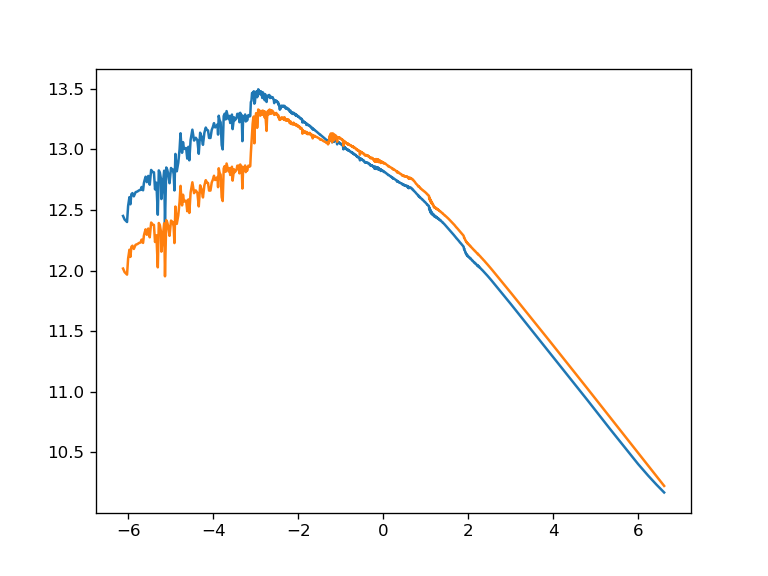

In [36]:
%matplotlib notebook
redshift =2
# plt.plot(jwst_waves, sed_interpolate)
plt.plot(np.log10(sed.sed.get_wavelength()/10**4)*((1+redshift)),np.log10(sed_simulation([0,0,-1]))/((1+redshift)))
plt.plot(np.log10(sed.sed.get_wavelength()/10**4)*((1+redshift)),np.log10(sed_simulation([np.log10(0.05),0,0]))/((1+redshift)))

#Weird or not weird??

In [32]:
filter_norm = np.sum((np.array(full_jwst_throughput[1:])+np.array(full_jwst_throughput[:-1])*full_delta_lambda))/2
print(filter_norm)

test_sed_interpolate = np.interp(2, np.log10(sed.sed.get_wavelength()), np.log10(sed_simulation([0,np.log(0.05),0])))
print(test_sed_interpolate)

379.91769210020067
37.63297411100507


In [12]:
file ='F070W'
%matplotlib notebook
data  = pd.read_csv("{0}.csv".format(file))
xdata = data.microns # Wavelength in units of micrometer
ydata = data.throughput # The throughput for each wavelength in jwst_wave
sed_waves = sed.use_wave/10**4

    
jwst_waves=[]
temp_jwst_waves=[]
for wave in xdata:
    temp_jwst_waves.append(wave)
    if wave>min_boundary and wave<max_boundary:
        jwst_waves.append(wave)

index_waves=[]           
for wave in jwst_waves:
    index = temp_jwst_waves.index(wave)
    index_waves.append(index)

print(index_waves[0])
delta_lambda=np.abs(np.array(jwst_waves[1:])-np.array(jwst_waves[:-1]))
                  
jwst_throughput = []

for throughput in ydata:
    jwst_throughput.append(throughput)

jwst_throughput=jwst_throughput[index_waves[0]:index_waves[len((index_waves))-1]+1]
function=within_filter_patchSED(jwst_waves,[0,0,0.05])
result = np.sum((function[1:]+function[:-1])*delta_lambda)/2
print(result)

jwst_throughput=jwst_throughput[index_waves[0]:index_waves[len((index_waves))-1]+1]
function=within_filter_patchSED(jwst_waves,[0,0,1])
result = np.sum((function[1:]+function[:-1])*delta_lambda)/2
print(result)

NameError: name 'min_boundary' is not defined